In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [3]:
import sys
import os

# Add the parent directory to the path to import from src
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../..')))

from src.forecaster import UnivariateForecaster

In [4]:
# Load the data from silver layer
data_path = '../../data/silver/forecast_data.csv'
df = pd.read_csv(data_path, index_col=0)

# Display the first few rows
display(df.head())

,Client_1,year,hour,is_business_hour,month,day_of_week,is_weekend,hour_sin,hour_cos,day_of_week_sin,...,lag_1,lag_24,diff_1,pct_change_1,diff_24,pct_change_24,rolling_mean_3,rolling_std_3,rolling_mean_7,rolling_std_7
2011-01-01 00:00:00,0.0,2011,0,0,1,5,1,0.000000,1.000000,-0.974928,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN
2011-01-01 01:00:00,0.0,2011,1,0,1,5,1,0.258819,0.965926,-0.974928,...,0.0,NaN,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0
2011-01-01 02:00:00,0.0,2011,2,0,1,5,1,0.500000,0.866025,-0.974928,...,0.0,NaN,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0
2011-01-01 03:00:00,0.0,2011,3,0,1,5,1,0.707107,0.707107,-0.974928,...,0.0,NaN,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0
2011-01-01 04:00:00,0.0,2011,4,0,1,5,1,0.866025,0.500000,-0.974928,...,0.0,NaN,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0


In [5]:
# Filter the DataFrame to keep only data from June 2012 onwards
df = df[df.index >= '2011-12-01']

# Display the updated DataFrame info
print(f"Data shape after filtering: {df.shape}")
print(f"Date range after filtering: {df.index.min()} to {df.index.max()}")

Data shape after filtering: (27049, 34)
Date range after filtering: 2011-12-01 00:00:00 to 2015-01-01 00:00:00


In [6]:
# Ensure the date column is in datetime format and set it as index
if 'date' in df.columns:
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)
elif 'timestamp' in df.columns:
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df.set_index('timestamp', inplace=True)

# Display basic info about the data
print(f"Data shape: {df.shape}")
print(f"Date range: {df.index.min()} to {df.index.max()}")
print(f"Available columns: {df.columns.tolist()}")


Data shape: (27049, 34)
Date range: 2011-12-01 00:00:00 to 2015-01-01 00:00:00
Available columns: ['Client_1', 'year', 'hour', 'is_business_hour', 'month', 'day_of_week', 'is_weekend', 'hour_sin', 'hour_cos', 'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos', 'day_of_year', 'week_of_year', 'quarter', 'is_month_start', 'is_month_end', 'time_of_day', 'is_morning', 'is_afternoon', 'is_evening', 'is_night', 'is_holiday', 'lag_1', 'lag_24', 'diff_1', 'pct_change_1', 'diff_24', 'pct_change_24', 'rolling_mean_3', 'rolling_std_3', 'rolling_mean_7', 'rolling_std_7']


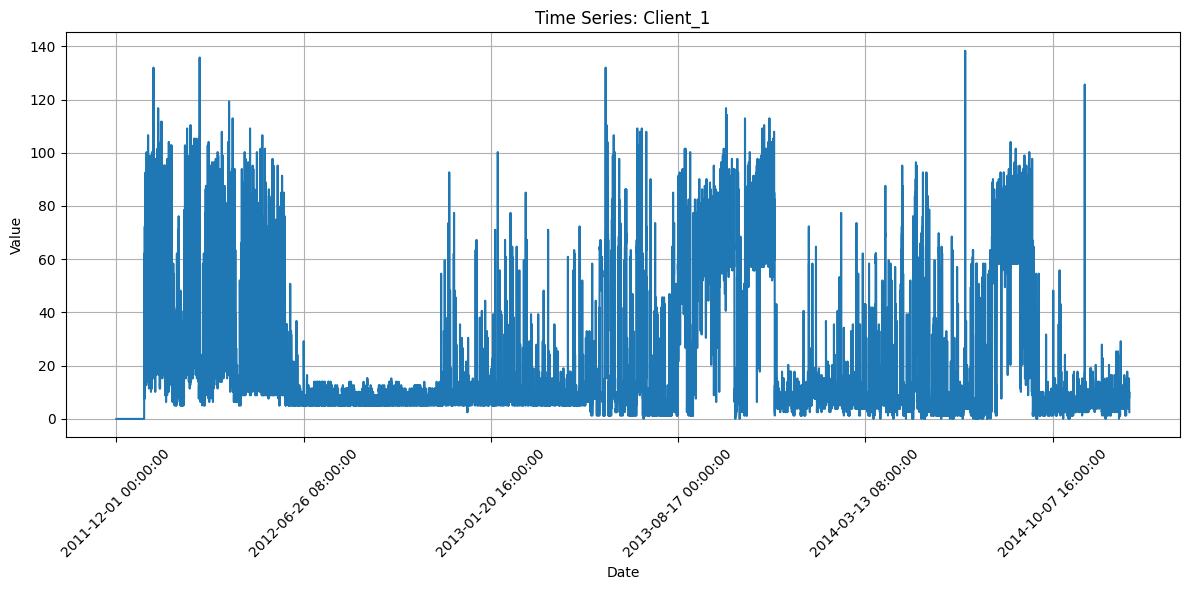

In [7]:
# ===============================
# 2. Prepare Time Series for Forecasting
# ===============================
# Assuming the target variable is in the first column, but we'll make it configurable
target_column = df.columns[0]  # Adjust this if needed

# Extract the target series
target_series = df[target_column]

# Plot the time series
plt.figure(figsize=(12, 6))
target_series.plot()
plt.title(f'Time Series: {target_column}')
plt.xlabel('Date')  # Annotate the x-axis labels
plt.ylabel('Value')
plt.xticks(rotation=45)  # Rotate the x-axis labels
plt.grid(True)
plt.tight_layout()
plt.show()


In [9]:
# ===============================
# 3. Initialize and Optimize Forecaster
# ===============================

# Set parameters for the forecaster
initial_window = 8760  # One full year of hourly data to capture all seasonal patterns
step_length = 168     # One week of data (24 hours × 7 days) for regular model updates
forecast_horizon = np.arange(1, 25)  # Forecast horizon of 24 steps (one full day ahead)

# Initialize the forecaster
forecaster = UnivariateForecaster(
    y=target_series,
    initial_window=initial_window,
    step_length=step_length,
    fh=forecast_horizon
)


🕒 PREPARING DATETIME INDEX
   Converting index to datetime...
✓ Successfully converted to DatetimeIndex


In [ ]:
# Run optimization to find the best model
# This may take some time depending on n_trials
n_trials = 10  # Number of trials for optimization
n_jobs = -1    # Use all available cores

print("Starting model optimization...")
forecast = forecaster.optimize(n_trials=n_trials, n_jobs=n_jobs)
print("Optimization complete!")

# Display the best model parameters
print("Best model parameters:")
best_params = forecaster.study.best_params
for param, value in best_params.items():
    print(f"  {param}: {value}")

print(f"\nBest model performance (RMSE): {forecaster.study.best_value:.4f}")

[I 2025-04-02 22:57:31,837] A new study created in memory with name: no-name-473c6dd9-2a03-4527-92f7-6d656d98dcd3


Starting model optimization...
Using pruner: <optuna.pruners._median.MedianPruner object at 0x0000026B1B6E2790>


[I 2025-04-02 22:57:41,934] Trial 4 finished with value: 21.148002683035006 and parameters: {'model': 'NaiveForecaster', 'strategy': 'mean'}. Best is trial 4 with value: 21.148002683035006.
[I 2025-04-02 22:57:49,958] Trial 1 finished with value: 20.899805976006572 and parameters: {'model': 'PolynomialTrendForecaster', 'degree': 1}. Best is trial 1 with value: 20.899805976006572.
[I 2025-04-02 22:57:50,490] Trial 7 finished with value: 21.000013594282606 and parameters: {'model': 'PolynomialTrendForecaster', 'degree': 3}. Best is trial 1 with value: 20.899805976006572.


KeyboardInterrupt: 

[I 2025-04-02 22:57:51,469] Trial 9 finished with value: 21.046945152812107 and parameters: {'model': 'PolynomialTrendForecaster', 'degree': 4}. Best is trial 1 with value: 20.899805976006572.


Forecasts:
2015-01-02    6.194794
2015-01-03    6.194794
2015-01-04    6.194794
2015-01-05    6.194794
2015-01-06    6.194794
2015-01-07    6.194794
2015-01-08    6.194794
2015-01-09    6.194794
2015-01-10    6.194794
2015-01-11    6.194794
2015-01-12    6.194794
2015-01-13    6.194794
2015-01-14    6.194794
2015-01-15    6.194794
2015-01-16    6.194794
2015-01-17    6.194794
2015-01-18    6.194794
2015-01-19    6.194794
2015-01-20    6.194794
2015-01-21    6.194794
2015-01-22    6.194794
2015-01-23    6.194794
2015-01-24    6.194794
2015-01-25    6.194794
Freq: 24h, Name: Client_1, dtype: float64


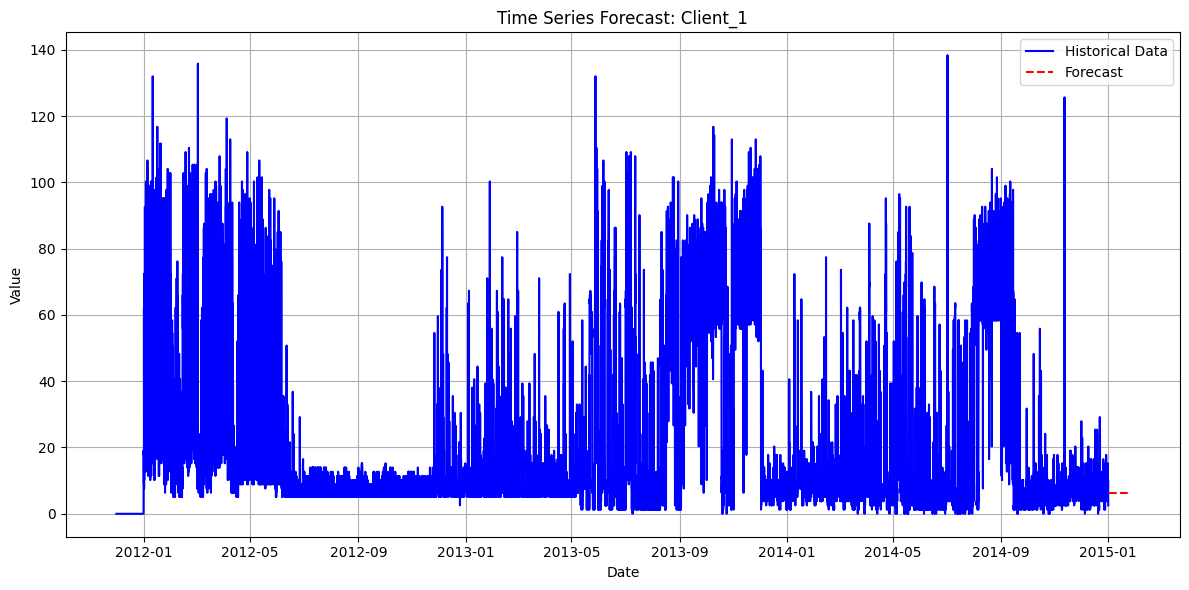

In [8]:
# ===============================
# 4. Generate and Visualize Forecasts
# ===============================

# Generate forecasts for the next time periods
forecast = forecaster.forecast(forecast_horizon*24)  # Forecast for the next 10 days (10*24 hours)

# Convert forecast to a DataFrame for better visualization
print("Forecasts:")
print(forecast)

# Plot the historical data and forecasts
plt.figure(figsize=(12, 6))

# Plot historical data
plt.plot(target_series.index, target_series.values, label='Historical Data', color='blue')

# Plot forecast
plt.plot(forecast.index, forecast.values, label='Forecast', color='red', linestyle='--')

plt.title(f'Time Series Forecast: {target_column}')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [9]:
# ===============================
# 5. Save the Results
# ===============================

# Create a DataFrame with both historical data and forecasts
results = pd.DataFrame({
    'actual': target_series,
    'forecast': pd.Series(data=np.nan, index=target_series.index)
})

# Add forecasts to the results DataFrame
results.loc[forecast.index, 'forecast'] = forecast

# Save the results to a CSV file
output_path = '../../data/gold/forecasting_results.csv'
os.makedirs(os.path.dirname(output_path), exist_ok=True)
results.to_csv(output_path)
print(f"Results saved to {output_path}")

# Show the tail of the results to see the forecasts
print(results.tail(15))

KeyError: "None of [DatetimeIndex(['2015-01-02', '2015-01-03', '2015-01-04', '2015-01-05',\n               '2015-01-06', '2015-01-07', '2015-01-08', '2015-01-09',\n               '2015-01-10', '2015-01-11', '2015-01-12', '2015-01-13',\n               '2015-01-14', '2015-01-15', '2015-01-16', '2015-01-17',\n               '2015-01-18', '2015-01-19', '2015-01-20', '2015-01-21',\n               '2015-01-22', '2015-01-23', '2015-01-24', '2015-01-25'],\n              dtype='datetime64[ns]', freq='24h')] are in the [index]"